In [116]:
import pandas as pd
import xarray as xr

dir_list_df = pd.read_csv('/user/ab5405/summeraliaclimate/code/dir_list.csv', index_col=0)
dir_list = dir_list_df['dir_path'].to_dict()


In [117]:
import os
{key: os.path.exists(path) for key, path in dir_list.items()}


{'proc': True,
 'raw': True,
 'aux': True,
 'geo': True,
 'pop': True,
 'mod': True,
 'obs': True}

In [118]:
df_paths['exp'].unique()

array(['ssp245', 'ssp585', 'ssp119', 'ssp126', 'ssp434', 'ssp534-over',
       'ssp370', 'ssp460'], dtype=object)

In [119]:
from funcs_support import get_filepaths

df_paths = get_filepaths(source_dir='proc', dir_list=dir_list)
df_paths.head()

,varname,freq,model,exp,run,gwl,proj_method,proj_base,dwnscl_method,dwnscl_target,suffix,filetype,path
0,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r22i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
1,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r1i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
2,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r2i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
3,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r11i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
4,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r25i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...


In [ ]:
'''
Make a map for just one model "IPSL-CM6A-LR" for change in days over 90 degrees
'''

In [120]:
path = df_sub['path'].iloc[0]
print(path)

/shared/share_hle/data/climate_proc/IPSL-CM6A-LR/tasdmgfparams_day_IPSL-CM6A-LR_ssp245_r22i1p1f1_ALLGWLS_projQDM-baseERA5-025_dwnsclQPLAD-target025deg_CONUS.zarr


In [121]:
ds_mini = xr.open_zarr(path)
ds_mini

<xarray.Dataset> Size: 34MB
Dimensions:          (bin_f: 22, bnds: 2, lat: 120, lon: 268, gwl: 6)
Coordinates:
  * bin_f            (bin_f) float64 176B 254.0 256.8 259.5 ... 309.5 312.3
  * bnds             (bnds) int64 16B 0 1
  * gwl              (gwl) float64 48B 0.61 1.0 1.5 2.0 2.5 3.0
  * lat              (lat) float64 960B 23.12 23.38 23.62 ... 52.38 52.62 52.88
  * lon              (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.38 -60.12
Data variables:
    bin_bnds_behrer  (bin_f, bnds) float64 352B dask.array<chunksize=(22, 2), meta=np.ndarray>
    bins_behrer      (lat, lon, gwl, bin_f) float64 34MB dask.array<chunksize=(120, 268, 1, 22), meta=np.ndarray>
Attributes:
    DESCRIPTION:  tasdmgfparams files, subset to CONUS and just F bins
    SOURCE:       deela transfer_for_alia.ipynb

In [122]:
print(ds_mini['bin_f'].values)

[253.98333333 256.76111111 259.53888889 262.31666667 265.09444444
 267.87222222 270.65       273.42777778 276.20555556 278.98333333
 281.76111111 284.53888889 287.31666667 290.09444444 292.87222222
 295.65       298.42777778 301.20555556 303.98333333 306.76111111
 309.53888889 312.31666667]


In [123]:
bin_mask = ds_mini['bin_f'] > 305.372
bin_f_above90 = ds_mini['bin_f'].where(bin_mask, drop=True)

In [124]:
for bin_f in ds_mini['bin_f']:
    gwl_2m = ds_mini['bins_behrer'].sel(gwl=2.0, bin_f=bin_f_above90)
    gwl_06m = ds_mini['bins_behrer'].sel(gwl=0.61, bin_f=bin_f_above90)
    diff = gwl_2m.sum('bin_f') - gwl_06m.sum('bin_f')

In [125]:
print(diff)

<xarray.DataArray 'bins_behrer' (lat: 120, lon: 268)> Size: 257kB
dask.array<sub, shape=(120, 268), dtype=float64, chunksize=(120, 268), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
  * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12


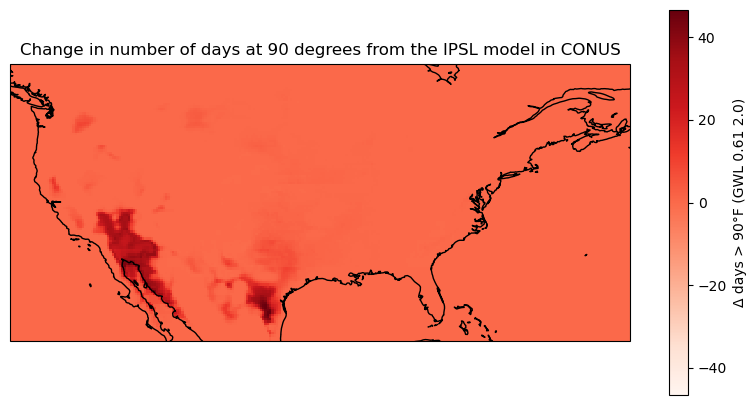

In [126]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_map(data, title):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': 'Δ days > 90°F (GWL 0.61 2.0)'})
    ax.coastlines()
    ax.set_title(title)
    plt.show()


plot_map(diff, "Change in number of days at 90 degrees from the IPSL model in CONUS")

In [ ]:
'''
1. loop through each model, and calculate the number of days in this bin between GWLs
2. calculate the aggregate mean between models, and then variances between models
3. calculate each model's mean and the variance between means
4. plot these using cartropy 
'''

In [127]:
#make a sub df with only experiments from ssp585
df_sub_new = df_paths.query("varname == 'tasdmgfparams' and exp == 'ssp585' and gwl == 'ALLGWLs'")

In [128]:
#copy it to a new dataframe as to not mess things up
df_ssp585 = df_sub_new.query("exp == 'ssp585'").copy()

In [129]:
#hooray now we make magic. Create three empty lists for which to create your fancy plots. Then, for each row, open 
#the zarr file and find gwl_2 and 0.61, from the 90F bin made before. Then, get the difference and append the 
#diffs to change_list. Append the model name from each row to model_labels, and the run name to run_labels.
change_list = []
model_labels = []
run_labels = []

for i, row in df_ssp585.iterrows():
    ds = xr.open_zarr(row['path'])
    bin_mask_1 = ds['bin_f'] > 305.372
    bin_f_above90n = ds['bin_f'].where(bin_mask_1, drop =True)
    gwl_2 = ds['bins_behrer'].sel(gwl = 2.0, bin_f = bin_f_above90n)
    gwl_06 = ds['bins_behrer'].sel(gwl= 0.61, bin_f = bin_f_above90n)
    diff = gwl_2.sum(dim='bin_f') - gwl_06.sum(dim='bin_f')
    
    change_list.append(diff)
    model_labels.append(row['model'])
    run_labels.append(row['run'])

In [130]:
#Create a change_stack, which essentially concatenates the change list into an array with the dimension run (i.e. 
#sorted by run at each latitude and longitude.
change_stack = xr.concat(change_list, dim='run')
change_stack.coords['model'] = ('run', model_labels)
change_stack.coords['run_label'] = ('run', run_labels)

In [131]:
mean_total = change_stack.mean(dim='run')
var_total = change_stack.var(dim='run')

# Mean variance across runs *within* models
within_var = change_stack.groupby('model').var(dim='run')
mean_within_var = within_var.mean(dim='model')

# Variance of model means
model_means = change_stack.groupby('model').mean(dim='run')
var_of_model_means = model_means.var(dim='model')


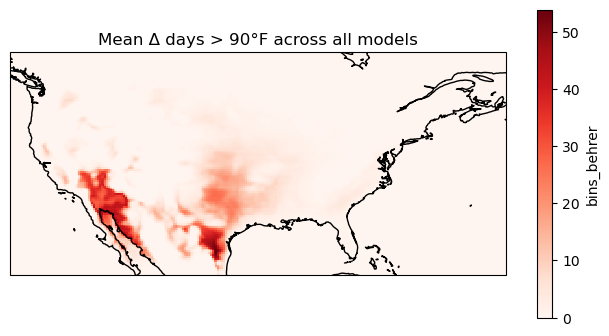

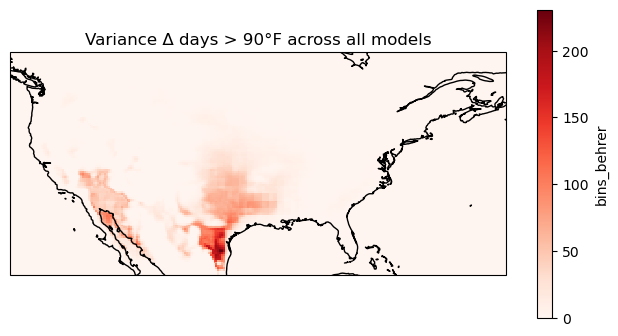

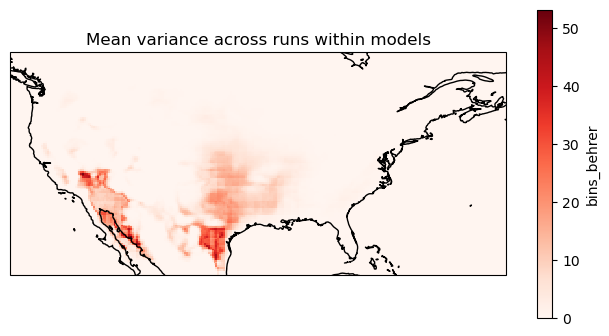

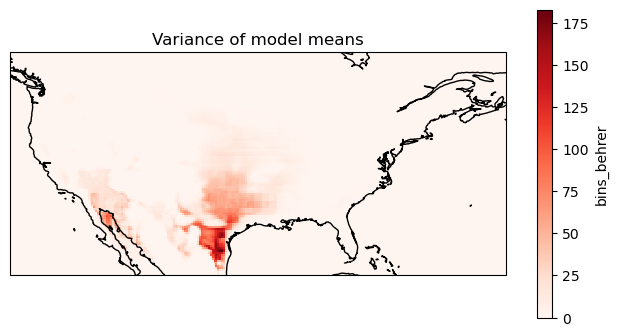

In [132]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_map(data, title):
    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, cmap='Reds')
    ax.coastlines()
    ax.set_title(title)
    plt.show()

plot_map(mean_total, "Mean Δ days > 90°F across all models")
plot_map(var_total, "Variance Δ days > 90°F across all models")
plot_map(mean_within_var, "Mean variance across runs within models")
plot_map(var_of_model_means, "Variance of model means")